In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import save_image
from model import *
import json

In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset_path = './dataset'
x_dim = 784

batch_size = 64

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# initialize model
model = VAE_expanding(input_size=((28,28)), device=DEVICE)

# Configuration
NUM_EPOCHS = 50
BATCH_SIZE = 128
GROWTH_EPOCH = 10
NB_NODE_ADD_1 = 5
NB_NODE_ADD_2 = 2
L_SAMPLE = 10

# Model configuration
INPUT_DIM = 784
HIDDEN1_DIM = 128
HIDDEN2_DIM = 64
LATENT_DIM = 20

# construct model with encoder and decoder configuration
Nb_nodes_added_1 = NB_NODE_ADD_1 * (NUM_EPOCHS // GROWTH_EPOCH -1)
Nb_nodes_added_2 = NB_NODE_ADD_2 * (NUM_EPOCHS // GROWTH_EPOCH -1)
encoder_config = [HIDDEN1_DIM + Nb_nodes_added_1, HIDDEN2_DIM + Nb_nodes_added_2, LATENT_DIM]
decoder_config = [HIDDEN2_DIM, HIDDEN1_DIM, INPUT_DIM]

model.construct(encoder_config, decoder_config)

model_name = f"VAE_{NUM_EPOCHS}_{BATCH_SIZE}_{LATENT_DIM}_{L_SAMPLE}"

model.load_state_dict(torch.load(f"saved_model/{model_name}.pth"))
model.eval()

RuntimeError: Error(s) in loading state_dict for VAE_expanding:
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([148, 784]) from checkpoint, the shape in current model is torch.Size([128, 784]).
	size mismatch for encoder.0.bias: copying a param with shape torch.Size([148]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.2.weight: copying a param with shape torch.Size([72, 148]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for encoder.2.bias: copying a param with shape torch.Size([72]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for hidden_to_mu.weight: copying a param with shape torch.Size([20, 72]) from checkpoint, the shape in current model is torch.Size([20, 64]).
	size mismatch for hidden_to_logvar.weight: copying a param with shape torch.Size([20, 72]) from checkpoint, the shape in current model is torch.Size([20, 64]).

torch.Size([64, 784])
torch.Size([64, 784])
Data shape: torch.Size([64, 784])


<Figure size 3000x1337.5 with 0 Axes>

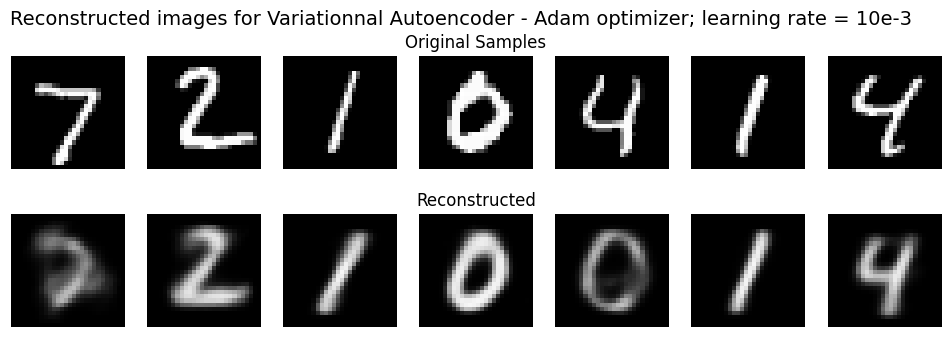

In [ ]:
model.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(batch_size, x_dim)
        
        print(img.shape)
        recon, _, _ = model(img.to(DEVICE))
        print(recon.shape)
        break
         
plt.figure(dpi=250, figsize=(12, 5.35))
fig, ax = plt.subplots(2, 7, figsize=(12, 3.75)) 

print("Data shape:", img.shape)

fig.suptitle("Reconstructed images for Variationnal Autoencoder - Adam optimizer; learning rate = 10e-3", fontsize=14)

for i in range(7):
    ax[0, i].imshow(img[i].cpu().numpy().reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    ax[1, i].imshow(recon[i].cpu().numpy().reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')

ax[0, 3].set_title('Original Samples', fontsize=12)
ax[1, 3].set_title('Reconstructed', fontsize=12)
plt.show()


### Generate sample from noise distribution

In [ ]:
with torch.no_grad():
    noise = torch.randn(batch_size, LATENT_DIM).to(DEVICE)
    generated_images = model.decoder(noise)

In [ ]:
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")
save_image(generated_images.view(batch_size, 1, 28, 28), f'img/{model_name}_{timestamp}.png')

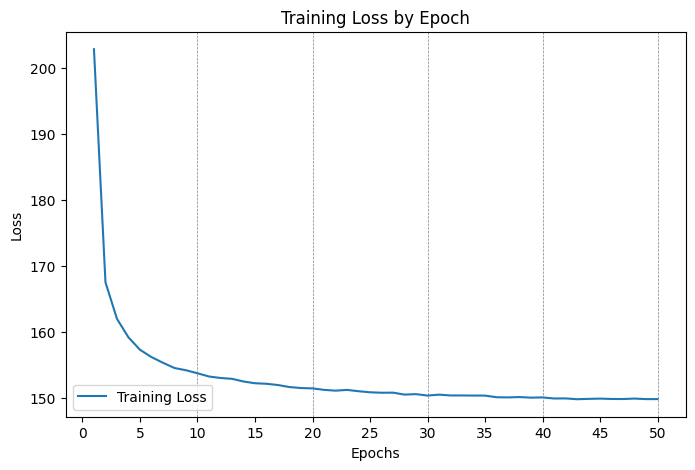

In [ ]:
# Load the training loss data
with open(f'saved_train-info/train_info{model_name}.json', 'r') as f:
    train_info = json.load(f)

# Plot the training loss
plt.figure(figsize=(8, 5))
epochs = range(1, len(train_info['loss_list']) + 1)

# LOSS
plt.plot(epochs, train_info['loss_list'], label='Training Loss')

# Add vertical dashed lines at x % 5 == 0
for x in epochs:
    if x % GROWTH_EPOCH == 0:
        plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(np.arange(0, len(epochs) + 1, 5))

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss by Epoch')
plt.legend()
plt.show()

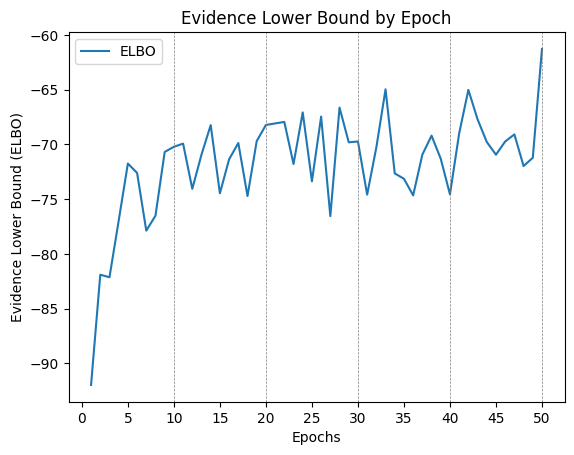

In [ ]:
# Plot the training loss
epochs = range(1, len(train_info['elbos']) + 1)
plt.plot(epochs, train_info['elbos'], label='ELBO')

# Add vertical dashed lines at x % 5 == 0
for x in epochs:
    if x % GROWTH_EPOCH == 0:
        plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(np.arange(0, len(epochs) + 1, 5))

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Evidence Lower Bound (ELBO)')
plt.title('Evidence Lower Bound by Epoch')
plt.legend()
plt.show()

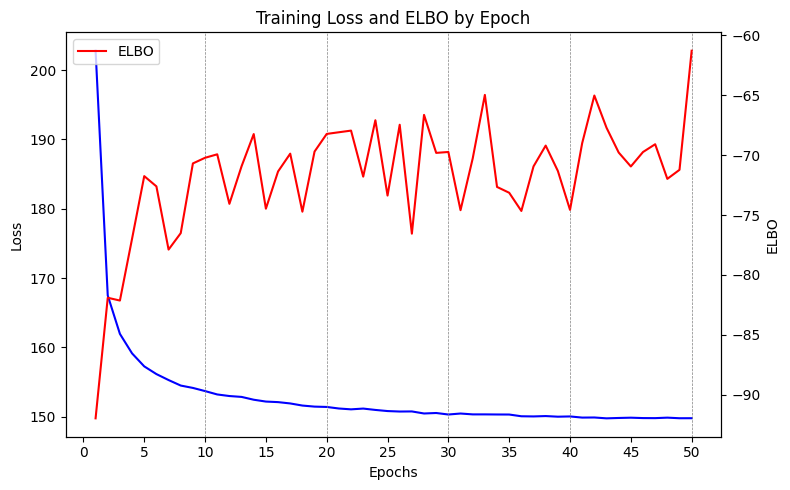

In [ ]:
# Plot the training loss
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_info['loss_list']) + 1)

# Plot LOSS on the first y-axis
ax1.plot(epochs, train_info['loss_list'], label='Training Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='y')


# Add vertical dashed lines at x % 5 == 0
for x in epochs:
    if x % GROWTH_EPOCH == 0:
        ax1.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

# Set x-axis to display every 5th epoch
ax1.set_xticks(np.arange(0, len(epochs) + 1, 5))

# Create a second y-axis for ELBO
ax2 = ax1.twinx()
ax2.plot(epochs, train_info['elbos'], label='ELBO', color='r')
ax2.set_ylabel('ELBO')
ax2.tick_params(axis='y')

# Add labels and title
plt.title('Training Loss and ELBO by Epoch')
plt.legend()
fig.tight_layout()  # Adjust layout to make room for both y-axes
plt.show()